In [1]:
import sys, os
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))

In [2]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
import matplotlib.patches as patches
from matplotlib import pyplot as plt

from light_models.keras_ssd300_squeezenetv1 import ssd_300

from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from extra_files import helper

%matplotlib inline

Using TensorFlow backend.


In [3]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
confidence_thresh=0.20

In [4]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='inference',
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels,
               confidence_thresh=confidence_thresh)

# 2: Load some weights into the model.
model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/squeezenet_v1.h5', by_name=True)

adam = Adam(lr=0.001)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
model.count_params()

3623476

In [7]:
from scipy import misc
file_label = pd.read_csv('/home/aldo/Documents/data-cic/preprocess_data/PASCAL_test.csv')
# get all images' names
file_column = file_label.columns
img_val = file_label[file_column[0]].unique()

normalized_label = []
predictions = np.zeros(shape=(1, 200, 6))

# Iterate over images
for start_i in range(0, len(img_val), 32):
    end_i = start_i + 32
    input_ = []
    for img_name in img_val[start_i:end_i]:
        img = imread('/home/aldo/Documents/data-cic/PASCAL' + '/' + img_name)
        height = img.shape[0]
        width = img.shape[1]

        # get labels from image
        original_label = file_label[file_label[file_column[0]] == img_name].values[:, 1:-1]

        # change formato from xmin, xmax, ymin, ymax to x, y, width, height
        new_label = []
        for o_label in original_label:
            new_label.append([o_label[0], o_label[2], o_label[1] - o_label[0], o_label[3]- o_label[2]])
            
        new_label = helper.normilize_boxes(new_label, width, height)
        normalized_label.append(new_label)

        # resize image
        resized_img= misc.imresize(img, size=(300, 300))
        input_.append(resized_img)
    input_ = np.array(input_)
    input_ = input_.reshape(-1, 300, 300, 3)
    pred = model.predict(input_)
    predictions = np.append(predictions, pred, axis=0)

predictions = predictions[1:] # delete empty item
 
# Remove class and confidence from predictions
predictions = helper.clean_predictions(predictions, id_class=1)
predictions = helper.adjust_predictions(predictions)
predictions = helper.get_coordinates(predictions)

/home/aldo/anaconda3/envs/test2/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [8]:
presicion, recall, f1_score = helper.cal_performance(normalized_label, predictions)

Number of images: 2097
Presicion: 0.5349
Recall: 0.4629
F1 score: 0.4963


In [9]:
#threshold 0.5
presicion, recall, f1_score = helper.cal_performance(normalized_label, predictions, iou=0.5)

Number of images: 2097
Presicion: 0.6044
Recall: 0.5433
F1 score: 0.5722


In [5]:
from scipy import misc
for size in ['xs', 's', 'm', 'l', 'xl']:
    file_label = pd.read_csv('/home/aldo/Documents/data-cic/preprocess_data/PASCAL_test_'+size+'.csv')
    # get all images' names
    file_column = file_label.columns
    img_val = file_label[file_column[0]].unique()

    normalized_label = []
    predictions = np.zeros(shape=(1, 200, 6))

    # Iterate over images
    for start_i in range(0, len(img_val), 32):
        end_i = start_i + 32
        input_ = []
        for img_name in img_val[start_i:end_i]:
            img = imread('/home/aldo/Documents/data-cic/PASCAL' + '/' + img_name)
            height = img.shape[0]
            width = img.shape[1]

            # get labels from image
            original_label = file_label[file_label[file_column[0]] == img_name].values[:, 1:-1]

            # change formato from xmin, xmax, ymin, ymax to x, y, width, height
            new_label = []
            for o_label in original_label:
                new_label.append([o_label[0], o_label[2], o_label[1] - o_label[0], o_label[3]- o_label[2]])

            new_label = helper.normilize_boxes(new_label, width, height)
            normalized_label.append(new_label)

            # resize image
            resized_img= misc.imresize(img, size=(300, 300))
            input_.append(resized_img)
        input_ = np.array(input_)
        input_ = input_.reshape(-1, 300, 300, 3)
        pred = model.predict(input_)
        predictions = np.append(predictions, pred, axis=0)

    predictions = predictions[1:] # delete empty item

    # Remove class and confidence from predictions
    predictions = helper.clean_predictions(predictions, id_class=1)
    predictions = helper.adjust_predictions(predictions)
    predictions = helper.get_coordinates(predictions)
    
    print(size)
    presicion, recall, f1_score = helper.cal_performance(normalized_label, predictions, iou=0.5)
    print()

/home/aldo/anaconda3/envs/test2/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


xs
Number of images: 1107
Presicion: 0.3197
Recall: 0.3004
F1 score: 0.3097

s
Number of images: 873
Presicion: 0.4638
Recall: 0.8365
F1 score: 0.5967

m
Number of images: 578
Presicion: 0.4903
Recall: 0.934
F1 score: 0.643

l
Number of images: 111
Presicion: 0.6437
Recall: 0.973
F1 score: 0.7748

xl
Number of images: 41
Presicion: 0.6833
Recall: 1.0
F1 score: 0.8119



In [5]:
def diagnostic_errors(predictions, ground_t):
    '''
    '''
    localization_error = 0
    correct = 0
    background = 0
    
    number_detection = 0
    for index_pred in range(len(predictions)):
        # Number of detections on the item
        number_detection += len(predictions[index_pred])
        # Iter each bounding box
        for item_to_eval in predictions[index_pred]:
            best_iou = helper.best_match(item_to_eval, ground_t[index_pred])
            if best_iou < 0.1:
                background += 1
            elif best_iou <= 0.5:
                localization_error += 1
            else:
                correct += 1
    print(number_detection)
    return correct, localization_error, background

In [6]:
from scipy import misc
file_label = pd.read_csv('/home/aldo/Documents/data-cic/preprocess_data/PASCAL_test.csv')
# get all images' names
file_column = file_label.columns
img_val = file_label[file_column[0]].unique()

normalized_label = []
predictions = np.zeros(shape=(1, 200, 6))

# Iterate over images
for start_i in range(0, len(img_val), 32):
    end_i = start_i + 32
    input_ = []
    for img_name in img_val[start_i:end_i]:
        img = imread('/home/aldo/Documents/data-cic/PASCAL' + '/' + img_name)
        height = img.shape[0]
        width = img.shape[1]

        # get labels from image
        original_label = file_label[file_label[file_column[0]] == img_name].values[:, 1:-1]

        # change formato from xmin, xmax, ymin, ymax to x, y, width, height
        new_label = []
        for o_label in original_label:
            new_label.append([o_label[0], o_label[2], o_label[1] - o_label[0], o_label[3]- o_label[2]])

        new_label = helper.normilize_boxes(new_label, width, height)
        normalized_label.append(new_label)

        # resize image
        resized_img= misc.imresize(img, size=(300, 300))
        input_.append(resized_img)
    input_ = np.array(input_)
    input_ = input_.reshape(-1, 300, 300, 3)
    pred = model.predict(input_)
    predictions = np.append(predictions, pred, axis=0)

predictions = predictions[1:] # delete empty item

# Remove class and confidence from predictions
predictions = helper.clean_predictions(predictions, id_class=1)
predictions = helper.adjust_predictions(predictions)
predictions = helper.get_coordinates(predictions)

correct, localization_error, background = diagnostic_errors(predictions, normalized_label)
print('correct:', correct)
print('localization error:', localization_error)
print('background:', background)
print('total detections:', correct + localization_error + background)

/home/aldo/anaconda3/envs/test2/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


4767
correct: 2881
localization error: 1285
background: 601
total detections: 4767


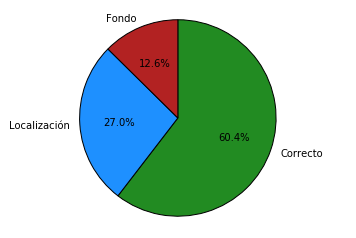

In [8]:
labels = ['Correcto', 'Localización', 'Fondo']
sizes = [correct, localization_error, background]
colors = ['forestgreen', 'dodgerblue', 'firebrick']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, counterclock=False, 
        wedgeprops={'edgecolor':'black','linewidth':1.0})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('falso_positivo_squeezenet.pdf', bbox_inches="tight")
plt.show()